## Gower clustering

#### Exploring the gower distance metric
A distance metric used to find clusters in ordinal data

$G S_{i j}=\frac{1}{m} \sum_{f=1}^{m} p s_{i j}^{(f)}$

Similarity between observations i and j. Having each observation m different features, either numerical, categorical or mixed.

$p s_{i j}^{(f)}=1-\frac{\left|x_{i f}-x_{j f}\right|}{R_{f}}$

Similarity between observation i and j in feature f when f is numerical. For a categorical feature, the partial similarity between two individuals is one only when both observations have exactly the same value for this feature. Zero otherwise.

$R_{f}=\max f-\min f$

Range of a feature f.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.datasets import make_classification
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
from extras import plot_confusion_matrix

## Multiclass example

In [3]:
# Creating a dictionary with the data
df = pd.DataFrame({"age": [22, 25, 30, 38, 42, 47, 55, 62, 61, 90], 
              "gender": ["M", "M", "F", "F", "F", "M", "M", "M", "M", "M"], 
              "civil_status": ["SINGLE", "SINGLE", "SINGLE", "MARRIED", "MARRIED", "SINGLE", "MARRIED", "DIVORCED", "MARRIED", "DIVORCED"], 
              "salary": [18000, 23000, 27000, 32000, 34000, 20000, 40000, 42000, 25000, 70000], 
              "has_children": [False, False, False, True, True, False, False, False, False, True], 
              "purchaser_type": ["LOW_PURCHASER", "LOW_PURCHASER", "LOW_PURCHASER", "HEAVY_PURCHASER", "HEAVY_PURCHASER", "LOW_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "LOW_PURCHASER"]})


In [4]:
df

,age,gender,civil_status,salary,has_children,purchaser_type
0,22,M,SINGLE,18000,False,LOW_PURCHASER
1,25,M,SINGLE,23000,False,LOW_PURCHASER
2,30,F,SINGLE,27000,False,LOW_PURCHASER
3,38,F,MARRIED,32000,True,HEAVY_PURCHASER
4,42,F,MARRIED,34000,True,HEAVY_PURCHASER
5,47,M,SINGLE,20000,False,LOW_PURCHASER
6,55,M,MARRIED,40000,False,MEDIUM_PURCHASER
7,62,M,DIVORCED,42000,False,MEDIUM_PURCHASER
8,61,M,MARRIED,25000,False,MEDIUM_PURCHASER
9,90,M,DIVORCED,70000,True,LOW_PURCHASER


In [5]:
d_matrix = gower.gower_matrix(df.drop("purchaser_type", axis=1))

In [6]:
customer_names = [f"c_{x}" for x in range(d_matrix.shape[0])]

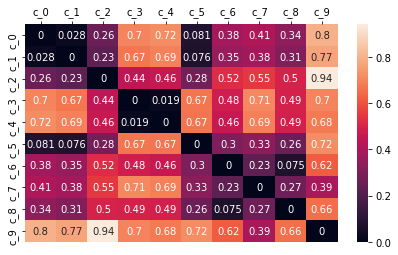

In [7]:
_ = plt.figure(figsize=(7,4))
ax = sns.heatmap(data=pd.DataFrame(d_matrix, index=customer_names, columns=customer_names),
               annot=True,
                fmt='.2g')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [8]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

In [9]:
# Fitting the clustering algorithm
dbscan_cluster.fit(d_matrix)

DBSCAN(eps=0.3, metric='precomputed', min_samples=2)

In [10]:
# Adding the results to a new column in the dataframe
df["DBSCAN_cluster"] = dbscan_cluster.labels_

In [11]:
l_matrix = linkage(d_matrix) 

<ipython-input-11-df338ac2b59e>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  l_matrix = linkage(d_matrix)


In [12]:
cld = fcluster(l_matrix, 3, criterion='maxclust')
df["linkage_cluster"] = cld

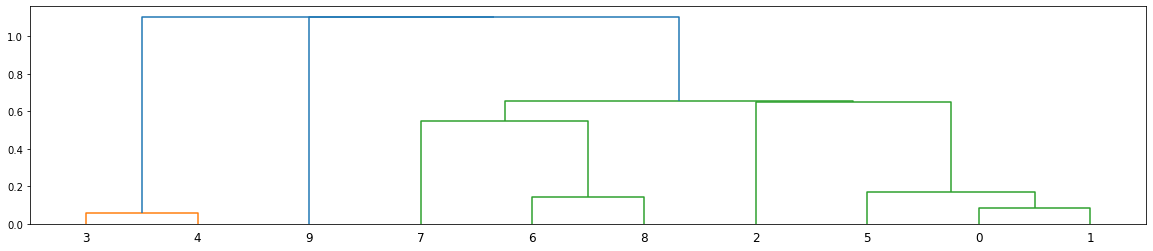

In [13]:
_ = plt.figure(figsize=(20, 4))
dn = dendrogram(l_matrix) 

In [14]:
df

,age,gender,civil_status,salary,has_children,purchaser_type,DBSCAN_cluster,linkage_cluster
0,22,M,SINGLE,18000,False,LOW_PURCHASER,0,2
1,25,M,SINGLE,23000,False,LOW_PURCHASER,0,2
2,30,F,SINGLE,27000,False,LOW_PURCHASER,0,2
3,38,F,MARRIED,32000,True,HEAVY_PURCHASER,1,1
4,42,F,MARRIED,34000,True,HEAVY_PURCHASER,1,1
5,47,M,SINGLE,20000,False,LOW_PURCHASER,0,2
6,55,M,MARRIED,40000,False,MEDIUM_PURCHASER,0,2
7,62,M,DIVORCED,42000,False,MEDIUM_PURCHASER,0,2
8,61,M,MARRIED,25000,False,MEDIUM_PURCHASER,0,2
9,90,M,DIVORCED,70000,True,LOW_PURCHASER,-1,3


In [15]:
ordered_cat = CategoricalDtype(['HEAVY_PURCHASER', 'LOW_PURCHASER', 'MEDIUM_PURCHASER'], ordered=True)

In [16]:
y_test = df["purchaser_type"].astype(ordered_cat).cat.codes + 1
y_pred = df["linkage_cluster"] 

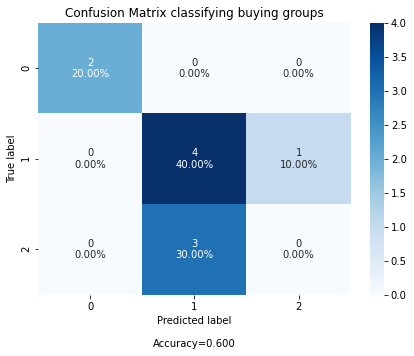

In [17]:
cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(cf=cf_matrix, title="Confusion Matrix classifying buying groups")

## Binary example

In [18]:
X, y = make_classification(n_samples=100, 
                             n_features=5, 
                             n_informative=5, 
                           n_redundant=0,
                            n_repeated=0,
                            n_classes=2,
                            n_clusters_per_class=2,
                             shuffle=True, 
                             random_state=42)

In [19]:
df = (pd.DataFrame(X, columns=[f"feat_{x}" for x in range(0, X.shape[1])]).round(0).astype(str)
.merge(pd.DataFrame(y, columns=["target"]),
      left_index=True,
      right_index=True))

In [20]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,target
0,-2.0,1.0,1.0,1.0,1.0,0
1,-1.0,-1.0,-1.0,1.0,2.0,1
2,-3.0,2.0,2.0,-1.0,1.0,0
3,-2.0,2.0,-3.0,-0.0,-1.0,1
4,-2.0,1.0,2.0,-1.0,1.0,0


In [21]:
d_matrix = gower.gower_matrix(df.drop("target", axis=1))

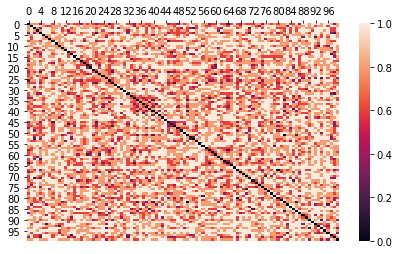

In [22]:
_ = plt.figure(figsize=(7,4))
ax = sns.heatmap(data=pd.DataFrame(d_matrix),
               annot=False,
                fmt='.2g')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [23]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

In [24]:
# Fitting the clustering algorithm
dbscan_cluster.fit(d_matrix)

DBSCAN(eps=0.3, metric='precomputed', min_samples=2)

In [25]:
# Adding the results to a new column in the dataframe
df["DBSCAN_cluster"] = dbscan_cluster.labels_

In [26]:
l_matrix = linkage(d_matrix) 

<ipython-input-26-df338ac2b59e>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  l_matrix = linkage(d_matrix)


In [27]:
cld = fcluster(l_matrix, 3, criterion='maxclust')
df["linkage_cluster"] = cld

In [28]:
# _ = plt.figure(figsize=(20, 4))
# dn = dendrogram(l_matrix) 

In [29]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,target,DBSCAN_cluster,linkage_cluster
0,-2.0,1.0,1.0,1.0,1.0,0,0,1
1,-1.0,-1.0,-1.0,1.0,2.0,1,-1,1
2,-3.0,2.0,2.0,-1.0,1.0,0,1,1
3,-2.0,2.0,-3.0,-0.0,-1.0,1,-1,1
4,-2.0,1.0,2.0,-1.0,1.0,0,1,1


In [30]:
y_test = df["target"]
y_pred = df["DBSCAN_cluster"] * -1

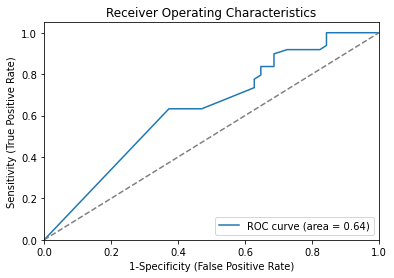

In [31]:
# Compute False postive rate, and True positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate Area under the curve to display on the plot
auc_score = roc_auc_score(y_test, y_pred, average="macro")
# Now, plot the computed values
_ = plt.plot(fpr, 
             tpr, 
             label="ROC curve (area = %0.2f)" % auc_score,)
# Custom settings for the plot
_ = plt.plot([0, 1], [0, 1], c="grey", ls="--")
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel("1-Specificity (False Positive Rate)")
_ = plt.ylabel("Sensitivity (True Positive Rate)")
_ = plt.title("Receiver Operating Characteristics")
_ = plt.legend(loc="lower right")